In [27]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import hstack
from sklearn.svm import SVC
from build_model import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
data = pd.read_csv('log_data.csv')
data = data.fillna('')
num_vars = ['favourites_count','followers_count','friends_count','listed_count','statuses_count',
                'avg_fav_cnt', 'avg_rt_cnt','max_fav_cnt','max_rt_cnt']

In [3]:
result = pd.DataFrame()
for vocab_size in [0.1,0.3,0.5]:
    models = {}
    for weight in ['balanced',None]:
        for C in [0.1,1,10,100]:
            models[str(weight)+str(C)] = SVC(C=C, 
                                            class_weight=weight,
                                            kernel='linear')
    result = result.append(cross_validation(vocab_size, models,data,0.2,7))

In [43]:
result[result.category=='Journalist'].sort_values(['category','model','vocab_size'])

,category,model,test_score,vocab_size
23,Journalist,None0.1,0.757282,0.1
23,Journalist,None0.1,0.747573,0.3
23,Journalist,None0.1,0.883495,0.5
22,Journalist,None1,0.815534,0.1
22,Journalist,None1,0.796117,0.3
22,Journalist,None1,0.941748,0.5
20,Journalist,None10,0.805825,0.1
20,Journalist,None10,0.825243,0.3
20,Journalist,None10,0.883495,0.5
16,Journalist,None100,0.776699,0.1


In [ ]:
result.to_csv('phase2_summary.csv',)

In [40]:
def customized_tfidf(X_train, X_test, y_train, category, var_name):
    categories = ['Politician', 'Trader', 'Journalist']
    text_cat = [' '.join(X_train[var_name][y_train == cat]) 
                for cat in categories]
    tfidf = TfidfVectorizer(min_df=1, sublinear_tf=True, stop_words='english')
    score_cat = tfidf.fit_transform(text_cat).toarray()[categories.index(category)]
    tfidf_train = tfidf.transform(X_train[var_name])
    tfidf_test = tfidf.transform(X_test[var_name])
    return {'tfidf': tfidf,
            'score': score_cat,
            'tfidf_train': tfidf_train,
            'tfidf_test': tfidf_test}

def customized_svc(category, C, vocab_size, i):
    result = []
    num_vars = ['favourites_count', 'followers_count', 'friends_count', 'listed_count', 'statuses_count',
                'avg_fav_cnt', 'avg_rt_cnt', 'max_fav_cnt', 'max_rt_cnt']
    X_train, X_test, y_train, y_test = train_test_split(data[num_vars + ['tweets', 'description']],
                                                        data.Category, test_size=0.2, random_state=i,
                                                        stratify=data.Category)
    tfidf_tweets = customized_tfidf(X_train, X_test, y_train, category, 'tweets')
    tfidf_description = customized_tfidf(X_train,X_test, y_train, category, 'description')
    
    sorted_twind = np.argsort(-tfidf_tweets['score'])
    remove_tw_ind = sorted_twind[int(vocab_size * len(sorted_twind)):]

    sorted_bioind = np.argsort(-tfidf_description['score'])
    remove_bio_ind = sorted_bioind[int(vocab_size * len(sorted_bioind)):]
    
    train_tw = np.delete(tfidf_tweets['tfidf_train'].toarray(), remove_tw_ind, axis=1)
    train_bio = np.delete(tfidf_description['tfidf_train'].toarray(), remove_bio_ind, axis=1)

    test_tw = np.delete(tfidf_tweets['tfidf_test'].toarray(), remove_tw_ind, axis=1)
    test_bio = np.delete(tfidf_description['tfidf_test'].toarray(), remove_bio_ind, axis=1)

    X_train_dtm = hstack((X_train[num_vars], train_bio, train_tw)).toarray()
    X_test_dtm = hstack((X_test[num_vars], test_bio, test_tw)).toarray()

    clf = SVC(C=C, random_state=i, kernel='linear')
    clf.fit(X_train_dtm, y_train==category)
    return [{'category':category,
            'C':C,
            'vocab_size':vocab_size,
            'test_score':clf.score(X_test_dtm, y_test==category)}]
            

    

In [44]:
summary = pd.DataFrame()
for i in range(30):
    summary = summary.append(customized_svc(category='Politician',C=1,vocab_size=0.1,i=i))
    print(i)
for i in range(30):
    summary = summary.append(customized_svc(category='Journalist',C=1,vocab_size=0.5,i=i))
    print(i)
for i in range(30):
    summary = summary.append(customized_svc(category='Trader',C=1,vocab_size=0.3,i=i))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [48]:
summary.groupby('category').agg({'test_score':[np.mean, np.std],
                                 'C':np.mean,
                                 'vocab_size': np.mean})

C test_score           vocab_size
           mean       mean       std       mean
category                                       
Journalist    1   0.862136  0.028665        0.5
Politician    1   0.939806  0.024375        0.1
Trader        1   0.945307  0.018992        0.3

(array([5., 3., 4., 2., 4., 2., 4., 2., 3., 1.]),
 array([0.81553398, 0.82621359, 0.8368932 , 0.84757282, 0.85825243,
        0.86893204, 0.87961165, 0.89029126, 0.90097087, 0.91165049,
        0.9223301 ]),
 <a list of 10 Patch objects>)

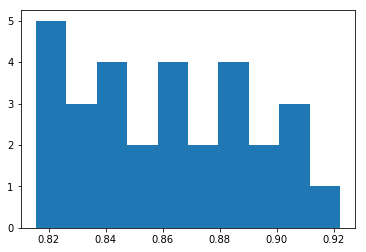

In [101]:
plt.hist(summary.test_score[summary.category=='Journalist'])

In [56]:
result = []
num_vars = ['favourites_count', 'followers_count', 'friends_count', 'listed_count', 'statuses_count',
                'avg_fav_cnt', 'avg_rt_cnt', 'max_fav_cnt', 'max_rt_cnt']
X_train, X_test, y_train, y_test = train_test_split(data[num_vars + ['tweets', 'description']],
                                                        data.Category, test_size=0.2, random_state=7,
                                                        stratify=data.Category)
def customized_svc(category, vocab_size):
    tfidf_tweets = customized_tfidf(X_train, X_test, y_train, category, 'tweets')
    tfidf_description = customized_tfidf(X_train,X_test, y_train, category, 'description')
    
    sorted_twind = np.argsort(-tfidf_tweets['score'])
    remove_tw_ind = sorted_twind[int(vocab_size * len(sorted_twind)):]

    sorted_bioind = np.argsort(-tfidf_description['score'])
    remove_bio_ind = sorted_bioind[int(vocab_size * len(sorted_bioind)):]
    
    train_tw = np.delete(tfidf_tweets['tfidf_train'].toarray(), remove_tw_ind, axis=1)
    train_bio = np.delete(tfidf_description['tfidf_train'].toarray(), remove_bio_ind, axis=1)

    test_tw = np.delete(tfidf_tweets['tfidf_test'].toarray(), remove_tw_ind, axis=1)
    test_bio = np.delete(tfidf_description['tfidf_test'].toarray(), remove_bio_ind, axis=1)

    X_train_dtm = hstack((X_train[num_vars], train_bio, train_tw)).toarray()
    X_test_dtm = hstack((X_test[num_vars], test_bio, test_tw)).toarray()

    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train_dtm, y_train==category)
    train_probs = clf.predict_proba(X_train_dtm)
    test_probs = clf.predict_proba(X_test_dtm)
    return clf, train_probs, test_probs
    

In [58]:
pol_clf, pol_train, pol_test = customized_svc('Politician', 0.1)
jour_clf, jour_train, jour_test = customized_svc('Journalist', 0.5)
trader_clf, trader_train, trader_test = customized_svc('Trader',0.3)

In [74]:
ensemble_train = pd.DataFrame({
    'category':y_train,
    'Politician':pol_train[:,1],
    'Journalist':jour_train[:,1],
    'Trader': trader_train[:,1]
})

ensemble_test = pd.DataFrame({
    'category':y_test,
    'Politician':pol_test[:,1],
    'Journalist':jour_test[:,1],
    'Trader': trader_test[:,1]
})
# ensemble_data['pol>jour'] = ensemble_data['Politician']>ensemble_data['Journalist']
# ensemble_data['pol>trader'] = ensemble_data['Politician']>ensemble_data['Trader']
# ensemble_data['trader>jour'] = ensemble_data['Trader']>ensemble_data['Journalist']

In [91]:
np.mean(ensemble_test[['Politician', 'Trader', 'Journalist']].idxmax(axis=1)==y_test)

0.8737864077669902

In [92]:
from sklearn.metrics import fbeta_score, recall_score, precision_score

In [93]:
fbeta_score(y_test, ensemble_test[['Politician', 'Trader', 'Journalist']].idxmax(axis=1),1,average='macro')

0.8673992673992674

In [95]:
precision_score(y_test, ensemble_test[['Politician', 'Trader', 'Journalist']].idxmax(axis=1),average='macro')

0.8657905217045002

In [96]:
recall_score(y_test, ensemble_test[['Politician', 'Trader', 'Journalist']].idxmax(axis=1),average='macro')

0.8738277919863598

In [108]:
categories = ['Politician', 'Trader', 'Journalist']
print('tweets')
text_cat = [' '.join(X_train['tweets'][y_train == cat]) 
                for cat in categories]
tfidf = TfidfVectorizer(min_df=1, sublinear_tf=True, stop_words='english')
score_cat = tfidf.fit_transform(text_cat).toarray()
vocab = tfidf.get_feature_names()
for i in range(3):
    print(categories[i])
    top_ind = np.argsort(-score_cat[i])[:7]
    print([vocab[j] for j in top_ind])

tweets
Politician
['wisen', 'wvlegi', 'wvchemleak', 'feingold', 'amp', 'teamronjon', 'council']
Trader
['eurusd', 'esf', 'forex', 'gbpusd', 'zulutradepnl', 'tgt', 'daytrad']
Journalist
['avlnew', 'wordwatch', 'newscentermain', 'toread', 'wkbtnew', 'wjtv', 'senzaglutin']


In [110]:
print('description')
text_cat = [' '.join(X_train['description'][y_train == cat]) 
                for cat in categories]
tfidf = TfidfVectorizer(min_df=1, sublinear_tf=True, stop_words='english')
score_cat = tfidf.fit_transform(text_cat).toarray()
vocab = tfidf.get_feature_names()
for i in range(3):
    print(categories[i])
    top_ind = np.argsort(-score_cat[i])[:7]
    print([vocab[j] for j in top_ind])

description
Politician
['councillor', 'senat', 'member', 'labour', 'conserv', 'minist', 'chair']
Trader
['trader', 'forex', 'stock', 'trade', 'fx', 'financi', 'option']
Journalist
['journalist', 'report', 'com', 'produc', 'editor', 'writer', 'photojournalist']
